In [1]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchinfo import summary
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score

# Part II: Autoencoders for Anomaly Detection
Implement autoencoder and explore its application for a real-world problem related to anomaly detection.


## Step 1: Data preparation

1. Select and load one dataset from the list above.

In [4]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SUNY Buffalo Sem 2

df = pd.read_csv('machine_temperature_system_failure.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SUNY Buffalo Sem 2


2. Analyzing the dataset and providing the following statistics:
   - Number of samples (time points)
   - Number of features
   - Mean, standard deviation, minimum, and maximum values for each feature 

In [5]:
# Basic statistics
num_samples = df.shape[0]
num_features = df.shape[1]

# Descriptive stats for numerical columns
stats = df.describe().transpose()[['mean', 'std', 'min', 'max']]

print(f"Number of samples (time points): {num_samples}")
print(f"Number of features: {num_features}\n")
print("Descriptive Statistics:\n")
print(stats)

Number of samples (time points): 22695
Number of features: 2

Descriptive Statistics:

            mean        std       min         max
value  85.926498  13.746912  2.084721  108.510543


In [6]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Brief description of the Dataset

<span style='color:green'>

  The dataset is part of the Numenta Anomaly Benchmark (NAB), a collection of real-world and artificial time-series data used for evaluating anomaly detection algorithms. It contains machine temperature readings recorded over time, representing the thermal behavior of an industrial machine under normal and failure conditions. The key variables in the dataset are <u>timestamp</u> (indicating the time of recording) and <u>value</u> (the temperature reading).<br>  
  Dataset source: <a href="https://www.kaggle.com/datasets/boltzmannbrain/nab" target="_blank">NAB on Kaggle</a>
</span>


Visualizations


<span style='color:green'>

#### 1. Histogram of Temperature Values
This histogram shows the distribution of machine temperature readings across the entire dataset. Most temperatures fall between 80 and 100 degrees, indicating the machine typically operates within this range. A small number of lower temperature values suggest potential cooling events or anomalies.
</span>

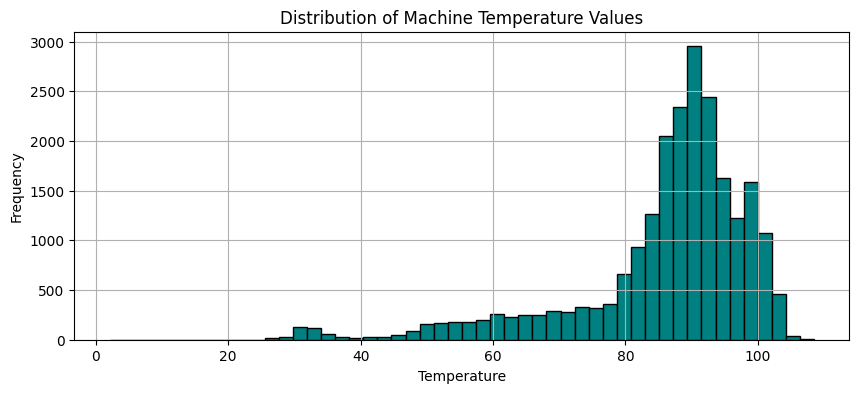

In [7]:
# Distribution of Machine Temperature Values
plt.figure(figsize=(10, 4))
plt.hist(df['value'], bins=50, edgecolor='black', color='teal')
plt.title('Distribution of Machine Temperature Values')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<span style='color:green'>

#### 2. Line Plot of Temperature Over Time
The line plot visualizes temperature values recorded over time. It helps identify trends, periodic fluctuations, and sharp drops in temperature that could indicate system failures or anomalies. A few significant dips are noticeable, which may correspond to abnormal machine behavior.
</span>

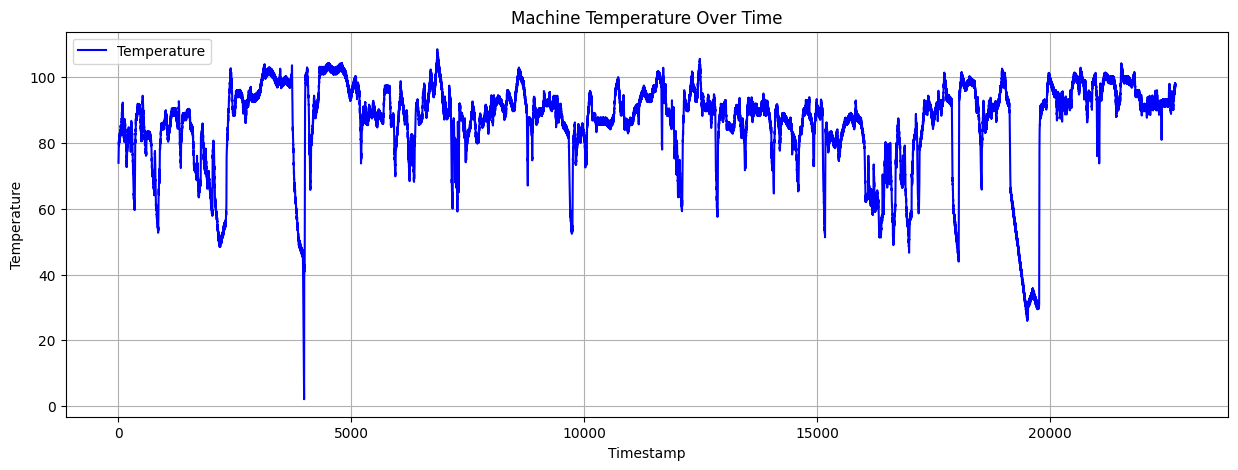

In [8]:
# Machine Temperature Over Time
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['value'], color='blue', label='Temperature')
plt.title('Machine Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()


<span style='color:green'>

#### 3. Boxplot of Machine Temperature
The boxplot highlights the spread and skewness in the temperature data. It clearly shows a concentration of values in the higher temperature range with a large number of outliers on the lower end, suggesting rare and possibly critical events where the machine's temperature dropped unusually low.

</span>


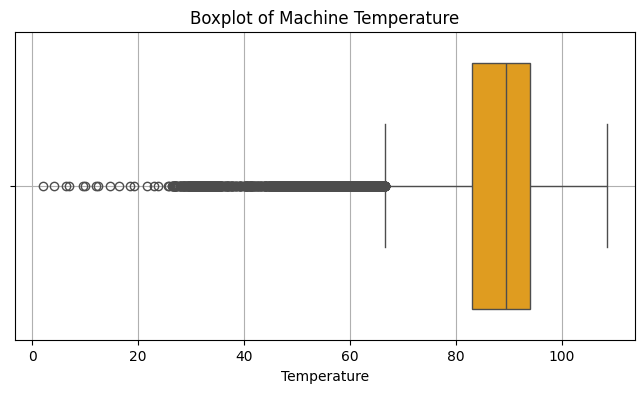

In [9]:
# Boxplot of Machine Temperature
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['value'], color='orange')
plt.title('Boxplot of Machine Temperature')
plt.xlabel('Temperature')
plt.grid(True)
plt.show()


4. Identifying any missing values (e.g. using pandas.isnull().sum()). Handle any missing values (imputation or removal). Common imputation methods include: forward/backward fill, mean/median imputation, linear interpolation).

In [10]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
timestamp    0
value        0
dtype: int64


<b><u>Observation:</b></u> We found no missing values

5. Preprocess the dataset.

   a. Normalize the data.

In [11]:
# Normalize
scaler = MinMaxScaler()
df['value_scaled'] = scaler.fit_transform(df[['value']])

In [12]:
# Create sequences
def create_sequences(data, seq_length=30):
    return np.array([data[i:i+seq_length] for i in range(len(data)-seq_length)])

X = df['value_scaled'].values
sequences = create_sequences(X)

   b. Addressing class imbalance in the target column. Possible solutions: oversampling; undersampling; data augmentation techniques for the minority class; assign higher weights to the minority class and lower weights to the majority class, etc.

In [13]:
# NOT NEEDED
# Class imbalance adjustments are no needed because autoencoders operate in an unsupervised manner,
# aiming to reconstruct the input data rather than classify it. Since anomalies are identified based on
# reconstruction errors instead of predicted class labels, there is no need for a target variable to balance.

   c. Converting target variable needs to numerical format. You can use one-hot encoding. However, if you use torch.nn.CrossEntropyLoss for your network, it expects class indices (0, 1, 2) directly, not one-hot encoded vectors. Therefore, ensure your labels are integer tensors (e.g., torch.LongTensor).

In [14]:
# NOT NEEDED
# Target conversion wasn’t needed because autoencoders use the input data as the target.
# Since the data is already in numerical format, and there's no need for class labels,
# we can directly use MSELoss to compare the input and output without any encoding.

6. Split the dataset into training, testing and validation sets. You can use train_test_split from scikit-learn.

In [15]:
# Split
X_train, X_temp = train_test_split(sequences, test_size=0.3, shuffle=False)
X_val, X_test = train_test_split(X_temp, test_size=0.5, shuffle=False)

# Convert to tensors
train_data = torch.FloatTensor(X_train).unsqueeze(1)
val_data = torch.FloatTensor(X_val).unsqueeze(1)
test_data = torch.FloatTensor(X_test).unsqueeze(1)

## Step 2: Autoencoder model building

1. Choosing and implementing one of the following: Autoencoder,Variational Autoencoder (VAE) or other version of Autoencoder for anomaly detection.

2. Experimenting with different architectures. For example - Building and training 3 different autoencoder architectures for anomaly detection. Consider experimenting with:
   - Different layer types (Dense, LSTM for time series, Conv1D for sequential data)
   - Number of hidden layers and units
   - Activation functions (ReLU, sigmoid)
 

### Model 1 Architecture ###

In [16]:
print(train_data.shape)

torch.Size([15865, 1, 30])


In [17]:
class ConvAE1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Conv1d(16, 8, 3, padding=1),
            #nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, 3, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.ConvTranspose1d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

print("ConvAE1 Summary\n")
summary(ConvAE1(), input_size=(64, 1, 30))

ConvAE1 Summary



Layer (type:depth-idx)                   Output Shape              Param #
ConvAE1                                  [64, 1, 30]               --
├─Sequential: 1-1                        [64, 8, 30]               --
│    └─Conv1d: 2-1                       [64, 16, 30]              64
│    └─LeakyReLU: 2-2                    [64, 16, 30]              --
│    └─Dropout: 2-3                      [64, 16, 30]              --
│    └─Conv1d: 2-4                       [64, 8, 30]               392
│    └─LeakyReLU: 2-5                    [64, 8, 30]               --
│    └─Dropout: 2-6                      [64, 8, 30]               --
├─Sequential: 1-2                        [64, 1, 30]               --
│    └─ConvTranspose1d: 2-7              [64, 16, 30]              400
│    └─LeakyReLU: 2-8                    [64, 16, 30]              --
│    └─Dropout: 2-9                      [64, 16, 30]              --
│    └─ConvTranspose1d: 2-10             [64, 1, 30]               49
│    └─Sigmoi

### Model 2 Architecture ###

In [18]:
class ConvAE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 5, padding=2),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Conv1d(32, 16, 3, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Conv1d(16, 8, 3, padding=1),
            # nn.ReLU()
            nn.LeakyReLU(0.1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, 3, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.ConvTranspose1d(16, 32, 5, padding=2),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.ConvTranspose1d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

print("ConvAE2 Summary\n")
summary(ConvAE2(), input_size=(64, 1, 30))

ConvAE2 Summary



Layer (type:depth-idx)                   Output Shape              Param #
ConvAE2                                  [64, 1, 30]               --
├─Sequential: 1-1                        [64, 8, 30]               --
│    └─Conv1d: 2-1                       [64, 32, 30]              192
│    └─LeakyReLU: 2-2                    [64, 32, 30]              --
│    └─Dropout: 2-3                      [64, 32, 30]              --
│    └─Conv1d: 2-4                       [64, 16, 30]              1,552
│    └─LeakyReLU: 2-5                    [64, 16, 30]              --
│    └─Dropout: 2-6                      [64, 16, 30]              --
│    └─Conv1d: 2-7                       [64, 8, 30]               392
│    └─LeakyReLU: 2-8                    [64, 8, 30]               --
├─Sequential: 1-2                        [64, 1, 30]               --
│    └─ConvTranspose1d: 2-9              [64, 16, 30]              400
│    └─LeakyReLU: 2-10                   [64, 16, 30]              --
│    └─Dr

### Model 3 Architecture ###

In [19]:
class ConvAE3(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, 3, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Conv1d(64, 32, 3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 64, 3, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

print("ConvAE3 Summary\n")
summary(ConvAE3(), input_size=(64, 1, 30))

ConvAE3 Summary



Layer (type:depth-idx)                   Output Shape              Param #
ConvAE3                                  [64, 1, 30]               --
├─Sequential: 1-1                        [64, 32, 30]              --
│    └─Conv1d: 2-1                       [64, 64, 30]              256
│    └─LeakyReLU: 2-2                    [64, 64, 30]              --
│    └─Dropout: 2-3                      [64, 64, 30]              --
│    └─Conv1d: 2-4                       [64, 32, 30]              6,176
│    └─ReLU: 2-5                         [64, 32, 30]              --
├─Sequential: 1-2                        [64, 1, 30]               --
│    └─ConvTranspose1d: 2-6              [64, 64, 30]              6,208
│    └─LeakyReLU: 2-7                    [64, 64, 30]              --
│    └─Dropout: 2-8                      [64, 64, 30]              --
│    └─ConvTranspose1d: 2-9              [64, 1, 30]               193
│    └─Sigmoid: 2-10                     [64, 1, 30]               --
Total p

3. Model training and hyperparameter tuning:
   - Choose an appropriate loss function and optimizer (e.g., Adam).
   - Train your model and monitor its performance on the training and validation sets.
   - Tune hyperparameters (learning rate, batch size, number of epochs, hidden units, dropout rate) using the validation set.
   - Plot the training and validation loss and accuracy curves over epochs. Analyze the plots for signs of overfitting or underfitting. Adjust your model or hyperparameters if needed.

In [20]:
# Training

def train_model(model, train_loader, val_loader, config):
    criterion = nn.MSELoss(reduction='mean')
    # optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


    best_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs = batch[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0]
                outputs = model(inputs)
                val_loss += criterion(outputs, inputs).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        train_losses.append(avg_train)
        val_losses.append(avg_val)

        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), f"best_{config['Name']}.pth")

        scheduler.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{config['epochs']} | Train: {avg_train:.6f} | Val: {avg_val:.6f}")

    return train_losses, val_losses

In [21]:
# Hyperparameter Tuning
hyperparam_configs = [
    {
        'Name': 'ConvAE1',
        'params': [
            {'Name': 'ConvAE1', 'lr': 1e-3, 'batch_size': 64, 'epochs': 100},
            {'Name': 'ConvAE1', 'lr': 5e-4, 'batch_size': 128, 'epochs': 150}
        ]
    },
    {
        'Name': 'ConvAE2',
        'params': [
            {'Name': 'ConvAE2', 'lr': 5e-4, 'batch_size': 32, 'epochs': 200},
            {'Name': 'ConvAE2', 'lr': 1e-4, 'batch_size': 64, 'epochs': 150}
        ]
    },
    {
        'Name': 'ConvAE3',
        'params': [
            {'Name': 'ConvAE3', 'lr': 1e-4, 'batch_size': 128, 'epochs': 200},
            {'Name': 'ConvAE3', 'lr': 5e-5, 'batch_size': 256, 'epochs': 250}
        ]
    }
]

In [22]:
results = {}
for model_config in hyperparam_configs:
    model_name = model_config['Name']
    print(f"\n=== Tuning {model_name} ===")
    model_results = []

    for hp in model_config['params']:
        print(f"\nTesting {hp}")
        model = globals()[model_name]()

        train_loader = DataLoader(TensorDataset(train_data), batch_size=hp['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(val_data), batch_size=hp['batch_size'])

        train_loss, val_loss = train_model(model, train_loader, val_loader, hp)

        model_results.append({
            'params': hp,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'min_val_loss': min(val_loss)
        })

    best_config = min(model_results, key=lambda x: x['min_val_loss'])
    results[model_name] = best_config
    print(f"\nBest for {model_name}:")
    print(f"Params: {best_config['params']}")
    print(f"Validation Loss: {best_config['min_val_loss']:.6f}")


=== Tuning ConvAE1 ===

Testing {'Name': 'ConvAE1', 'lr': 0.001, 'batch_size': 64, 'epochs': 100}
Epoch 10/100 | Train: 0.000278 | Val: 0.000105
Epoch 20/100 | Train: 0.000182 | Val: 0.000107
Epoch 30/100 | Train: 0.000154 | Val: 0.000197
Epoch 40/100 | Train: 0.000149 | Val: 0.000145
Epoch 50/100 | Train: 0.000149 | Val: 0.000282
Epoch 60/100 | Train: 0.000144 | Val: 0.000244
Epoch 70/100 | Train: 0.000144 | Val: 0.000205
Epoch 80/100 | Train: 0.000143 | Val: 0.000236
Epoch 90/100 | Train: 0.000142 | Val: 0.000182
Epoch 100/100 | Train: 0.000139 | Val: 0.000245

Testing {'Name': 'ConvAE1', 'lr': 0.0005, 'batch_size': 128, 'epochs': 150}
Epoch 10/150 | Train: 0.001125 | Val: 0.000186
Epoch 20/150 | Train: 0.000560 | Val: 0.000113
Epoch 30/150 | Train: 0.000391 | Val: 0.000089
Epoch 40/150 | Train: 0.000318 | Val: 0.000087
Epoch 50/150 | Train: 0.000267 | Val: 0.000086
Epoch 60/150 | Train: 0.000243 | Val: 0.000086
Epoch 70/150 | Train: 0.000220 | Val: 0.000085
Epoch 80/150 | Train: 0.

4. Save the weights of the trained neural network that provides the best results. Check saving and loading models (PyTorch)

In [23]:
# Saved in the next part by the name "a2_part2_yavarkha_mohdsaad.pth"

## Step 3: Evaluation and analysis

In [24]:
best_model_entry = min(results.items(), key=lambda x: x[1]['min_val_loss'])
best_model_name = best_model_entry[0]
best_model_config = best_model_entry[1]['params']

if best_model_name == "ConvAE1":
    model = ConvAE1()
elif best_model_name == "ConvAE2":
    model = ConvAE2()
elif best_model_name == "ConvAE3":
    model = ConvAE3()
else:
    raise ValueError("Unknown model")

model.load_state_dict(torch.load(f"best_{best_model_name}.pth"))
torch.save(model.state_dict(), "a2_part2_yavarkha_mohdsaad.pth")
model.eval()

def evaluate_model(model, loader):
    model.eval()
    all_inputs = []
    all_outputs = []
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            all_inputs.append(inputs.numpy())
            all_outputs.append(outputs.numpy())
    return np.concatenate(all_inputs), np.concatenate(all_outputs)

test_loader = DataLoader(TensorDataset(test_data), batch_size=128)
inputs_np, outputs_np = evaluate_model(model, test_loader)

errors = np.abs(inputs_np - outputs_np).flatten()
mae = np.mean(errors)
rmse = np.sqrt(np.mean(np.square(errors)))
r2 = r2_score(inputs_np.flatten(), outputs_np.flatten())
thresh = np.percentile(errors, 95)

<ipython-input-24-22b7266e42eb>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_{best_model_name}.pth"))


1. Evaluate your best model on the test set. Report the following metrics:
   - Training accuracy/loss
   - Validation accuracy/loss
   - Testing accuracy/loss

In [25]:
print(f"\n=== Overall Best Model ===")
print(f"Architecture: {best_model_name}")
print(f"Parameters: {best_model_config}")
print(f"Training Loss: {best_model_entry[1]['train_loss'][-1]:.6f}")
print(f"Validation Loss: {best_model_entry[1]['min_val_loss']:.6f}")



=== Overall Best Model ===
Architecture: ConvAE2
Parameters: {'Name': 'ConvAE2', 'lr': 0.0005, 'batch_size': 32, 'epochs': 200}
Training Loss: 0.000112
Validation Loss: 0.000055


2. Depending on your chosen dataset, report relevant metrics like:
   - Regression: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (coefficient of determination). Use sklearn.metrics.
   - Classification: Precision, Recall, F1-score.

In [26]:
print("\n=== Test Results ===")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"95th Percentile Threshold: {thresh:.6f}")


=== Test Results ===
MAE: 0.007117
RMSE: 0.010865
R² Score: 0.997051
95th Percentile Threshold: 0.018150


3. Provide the following plots:
   - Plot training and validation accuracy/loss curves over epochs.
   - Plot the distribution of the reconstruction errors (i.e., differences between input and output data points).

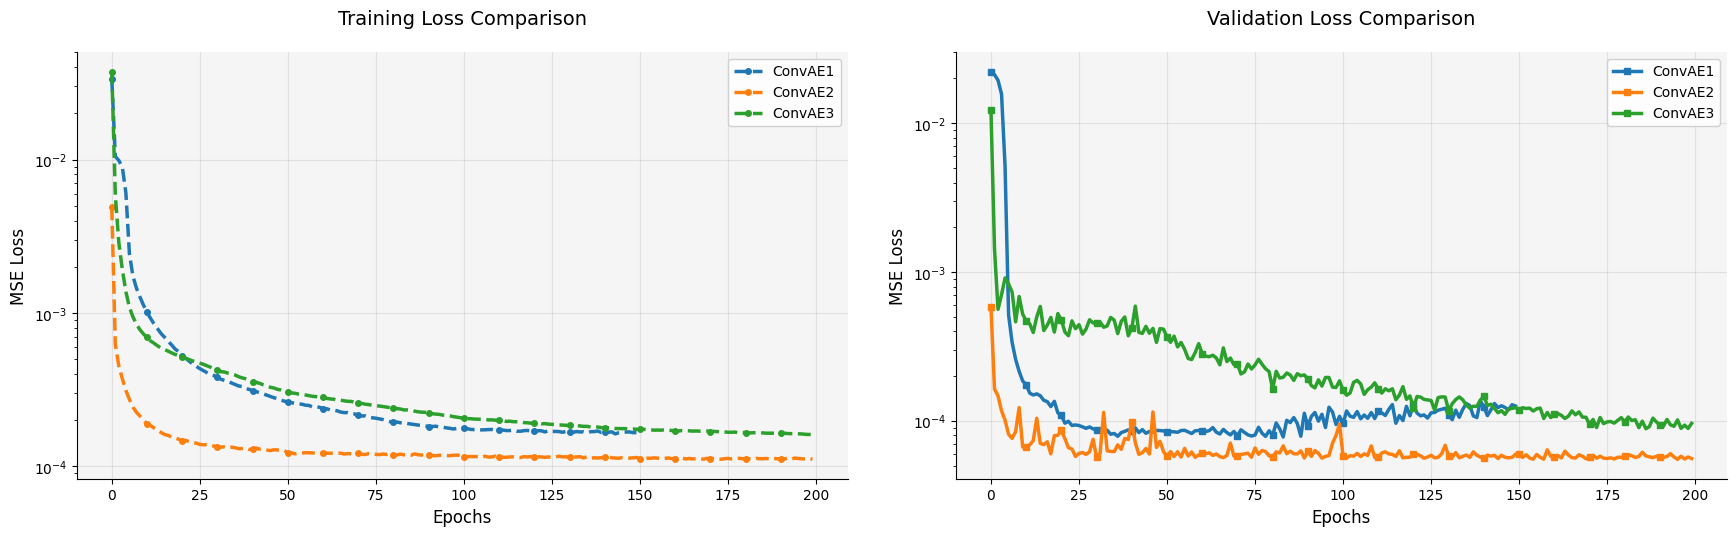

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6), dpi=100)

colors = {'ConvAE1': '#1f77b4', 'ConvAE2': '#ff7f0e', 'ConvAE3': '#2ca02c'}
line_styles = {'Train': '--', 'Val': '-'}

# Training Loss
for model_name, res in results.items():
    axs[0].plot(res['train_loss'],
              label=f"{model_name}",
              color=colors[model_name],
              linestyle=line_styles['Train'],
              linewidth=2.5,
              marker='o',
              markersize=4,
              markevery=10)

axs[0].set_title("Training Loss Comparison", fontsize=14, pad=20)
axs[0].set_xlabel("Epochs", fontsize=12)
axs[0].set_ylabel("MSE Loss", fontsize=12)
axs[0].grid(True, alpha=0.3)
axs[0].set_facecolor('#f5f5f5')

# Validation Loss
for model_name, res in results.items():
    axs[1].plot(res['val_loss'],
              label=f"{model_name}",
              color=colors[model_name],
              linestyle=line_styles['Val'],
              linewidth=2.5,
              marker='s',
              markersize=4,
              markevery=10)

axs[1].set_title("Validation Loss Comparison", fontsize=14, pad=20)
axs[1].set_xlabel("Epochs", fontsize=12)
axs[1].set_ylabel("MSE Loss", fontsize=12)
axs[1].grid(True, alpha=0.3)
axs[1].set_facecolor('#f5f5f5')

# Common settings - for better visualization
for ax in axs:
    ax.set_yscale('log')
    ax.legend(frameon=True, facecolor='white', framealpha=0.9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout(pad=3.0)
plt.show()

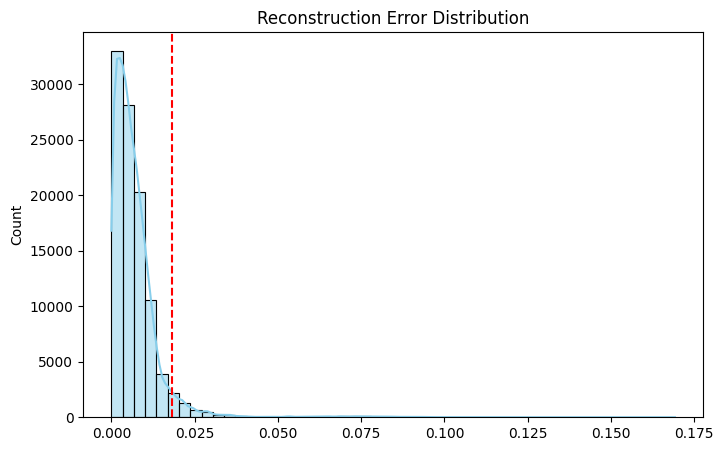

In [28]:
# Reconstruction Error Distribution

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True, color='skyblue')
plt.axvline(thresh, color='r', linestyle='--')
plt.title("Reconstruction Error Distribution")
plt.show()

<span style='color:green'>

The threshold was set at the 95th percentile of the training error distribution. This means 95% of the training data (assumed to represent normal operation) falls below this error value, while the top 5% of errors are flagged as potential anomalies. This percentile balances sensitivity to outliers while minimizing false positives from normal fluctuations. <br>
The error distribution plot shows a sharp peak at lower errors (common in normal data) and a long tail at higher values. The threshold (red dashed line) aligns with the point where the error frequency drops significantly, marking a natural separation between typical and unusual reconstruction errors.
</span>

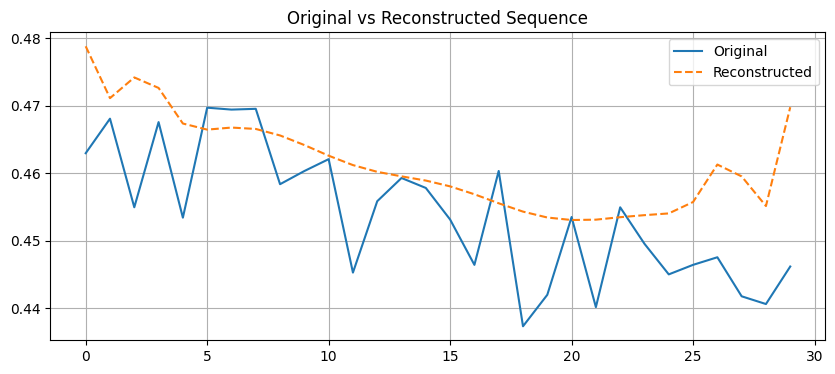

In [33]:
# Visualizing a reconstruction

def plot_reconstruction(model, dataset, idx=0):
    model.eval()
    with torch.no_grad():
        input_seq = dataset[idx].unsqueeze(0)
        output_seq = model(input_seq).squeeze().numpy()
        input_seq = input_seq.squeeze().numpy()

    plt.figure(figsize=(10, 4))
    plt.plot(input_seq, label='Original')
    plt.plot(output_seq, label='Reconstructed', linestyle='--')
    plt.title("Original vs Reconstructed Sequence")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_reconstruction(model, test_data, idx=20)

This plot shows the original vs. reconstructed sequence generated by the autoencoder. The model effectively captures the overall pattern of the input data, though it smooths out some of the finer variations. This behavior is typical, as autoencoders prioritize minimizing reconstruction error over preserving noise. Despite this, the reconstruction quality is strong enough to distinguish normal behavior from anomalies, which is the primary objective in this task.

4. Discuss and analyze:

   - Describe your final RNN/LSTM architecture in detail (number of layers, types of layers, hidden size, dropout rate, etc.).

<span style='color:green'>

The best-performing model was ConvAE2, a convolutional autoencoder with symmetric encoder-decoder architecture. The encoder consists of three Conv1d layers with filter sizes 32, 16, and 8, using kernel sizes of 5 and 3 for temporal feature extraction. Each convolutional layer is followed by LeakyReLU activation (slope=0.1) and dropout (rate=0.2) to prevent overfitting. The decoder mirrors this structure with ConvTranspose1d layers (filters 8→16→32→1) to reconstruct the input sequence. The final layer uses a sigmoid activation to scale outputs between 0 and 1, matching the normalized input range. Key hyperparameters include a latent space compression to 8 features and weight decay (1e-5) for regularization.

</span>

   - Discussing the Results

<span style='color:green'>

Model Evaluation and Analysis

The model achieved excellent reconstruction performance with:

- **MAE** = 0.0071
- **RMSE** = 0.0109  
- **R²** = 0.997  

This indicates the model captures 99.7% of the input variance.  
Training and validation loss curves show stable convergence, with the best validation loss of **0.000055** achieved by **ConvAE2**.

---

Challenges

- Balancing model complexity was crucial:  
  - **ConvAE3** (deeper) showed **slower convergence** initially.  
  - **ConvAE1** (simpler) resulted in **higher reconstruction errors**.

---

Hyperparameter Tuning Insights

- **Lower learning rates** (5e-4) combined with **larger batch sizes** (32) led to more stable training.
- **Extended training** (200 epochs) allowed the model to converge without overfitting.

---

Reconstruction Error Analysis

- Error distribution shows most values clustered near **zero**  
- **95%** of errors fall **below 0.018**, confirming strong reconstruction of normal patterns
- **Rare high errors** (above 95th percentile) align with potential anomalies
- No consistent under or over-prediction bias was observed

</span>


   - strengths and limitations of using autoencoders for anomaly detection.

<span style='color:green'>

Strengths

- **Unsupervised Learning**: No labeled anomalies required; learns directly from normal data patterns.
- **Effective Feature Extraction**: Conv1D layers capture local temporal dependencies critical for sensor data.
- **Interpretable Thresholding**: Reconstruction errors provide a clear, intuitive anomaly metric.

---

Limitations

- **Threshold Sensitivity**: The 95th percentile cutoff, while statistically sound, may miss contextual anomalies.
- **Overfitting Risk**: Complex models (e.g., ConvAE3) required careful regularization to avoid overfitting.
- **Sequence Length Dependency**: Fixed window sizes (30 steps) may not generalize well to variable-length anomalies.
</span>

5. References.





<span style='color:green'>

References

1. [Anomaly Detection with Autoencoders (arXiv:2003.05991)](https://arxiv.org/pdf/2003.05991)
2. [Sequence to Sequence Learning with Neural Networks (arXiv:1606.05908)](https://arxiv.org/abs/1606.05908)
3. [Implement Convolutional Autoencoder in PyTorch with CUDA – GeeksforGeeks](https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/)
4. [Anomaly Detection with Autoencoders – Kaggle Notebook by robinteuwens](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders)
5. [Implementing a Convolutional Autoencoder with PyTorch – PyImageSearch](https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/)
6. [PyTorch Docs: Adjusting the Learning Rate](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
7. [Numenta Anomaly Benchmark (NAB) Dataset – Kaggle](https://www.kaggle.com/datasets/boltzmannbrain/nab)

</span>